In [21]:

from rdkit import Chem
from rdkit.Chem import rdMolDescriptors
import pathlib, pickle, os, tqdm, torch
import multiprocessing, collections

from collections import defaultdict  

RADIUS_UPPER_LIMIT = 10
DATASET_root_path = pathlib.Path("/workspace/")
DATASETS = ["OneD_Only_Dataset", "SMILES_dataset"]
DATASET_INDEX_SOURCE = ["oneD_NMR" , "HSQC"]

from rdkit.Chem import rdFingerprintGenerator
gen = rdFingerprintGenerator.GetMorganGenerator(radius=RADIUS_UPPER_LIMIT)
ao = rdFingerprintGenerator.AdditionalOutput()
ao.AllocateBitInfoMap()

from rdkit import RDLogger

RDLogger.DisableLog('rdApp.*')  # Disable all RDKit warnings


def isomeric_to_canonical_smiles(isomeric_smiles):
    try:
        mol = Chem.MolFromSmiles(isomeric_smiles)
        Chem.RemoveStereochemistry( mol ) 
    except:
        # print(isomeric_smiles)
        return None

    canonical_smiles = Chem.MolToSmiles(mol, canonical=True)
    
    return canonical_smiles


In [30]:
RADIUS_UPPER_LIMIT = 3
from rdkit.Chem import rdFingerprintGenerator
gen = rdFingerprintGenerator.GetMorganGenerator(radius=RADIUS_UPPER_LIMIT)
ao = rdFingerprintGenerator.AdditionalOutput()
ao.AllocateBitInfoMap()


def get_fragments_v1(SMILES):
    # get fragments from bits from mfp
    mol = Chem.MolFromSmiles(SMILES)
    if mol is None:
        print(f"Failed to parse {SMILES}")
        # raise ValueError(f"Failed to parse {SMILES}")
        return None
    Chem.Kekulize(mol, clearAromaticFlags=True)
    mol = Chem.AddHs(mol)

    # Compute Morgan fingerprint with radius 
    fp = gen.GetFingerprint(mol, additionalOutput=ao)
    info = ao.GetBitInfoMap()
    
    # Extract circular subgraphs
    # display(info)
    frags = set()
    for bit_id, atom_envs in info.items():
        for atom_idx, curr_radius in atom_envs:
            # Get the circular environment as a subgraph
            env = Chem.FindAtomEnvironmentOfRadiusN(mol, curr_radius, atom_idx)
            submol = Chem.PathToSubmol(mol, env)
            smiles = Chem.MolToSmiles(submol, canonical=True) # this is canonical in terms of fragment, so it is related to the bond/atom index mapping
            smiles = Chem.MolToSmiles(Chem.MolFromSmiles(smiles), canonical=True) # so, let's treat it as a independent molecule, instead of a fragment
            frags.add(smiles)
    
    frags.discard("")
    return frags

In [31]:


def get_fragments_v2(SMILES):
    # get fragments from each index and a given radius
    mol = Chem.MolFromSmiles(SMILES)
    if mol is None:
        print(f"Failed to parse {SMILES}")
        # raise ValueError(f"Failed to parse {SMILES}")
        return None
    Chem.Kekulize(mol, clearAromaticFlags=True)
    mol = Chem.AddHs(mol)

    frags = set()
    for atom_idx in range(mol.GetNumAtoms()):
        for radius in range(1, RADIUS_UPPER_LIMIT + 1):
            env = Chem.FindAtomEnvironmentOfRadiusN(mol, radius, atom_idx)
            submol = Chem.PathToSubmol(mol, env)
            smiles = Chem.MolToSmiles(submol, canonical=True)
            smiles = Chem.MolToSmiles(Chem.MolFromSmiles(smiles), canonical=True)

            frags.add(smiles)
    frags.discard("")
    return frags

In [32]:
Kavaratamide_A_SMILES = "CCCCCCC[C@H](O)CC(=O)N[C@@H](C(C)C)C(=O)N(C)[C@@H](C)C(=O)O[C@@H](C(C)C)C(=O)N1[C@@H](C(C)C)C(OC)=CC1=O"
Kavaratamide_A_SMILES = isomeric_to_canonical_smiles(Kavaratamide_A_SMILES)
s_old = "CCCCCCCC(CC=CCCC(=O)N(C)C(C)C(=O)NC(C)C(O)C(C)C(=O)N1C(=O)C=C(OC)C1C(C)C)OC"
s_new = "CCCCCCC(O)CC(=O)NC1CCOC1=O"

Kav_mol = Chem.MolFromSmiles(Kavaratamide_A_SMILES)
s_old_mol = Chem.MolFromSmiles(s_old)
s_new_mol = Chem.MolFromSmiles(s_new)

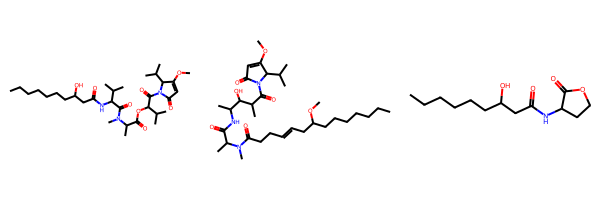

In [33]:
Chem.Draw.MolsToImage([Kav_mol, s_old_mol, s_new_mol ])

In [34]:
kav_frags = get_fragments_v1(Kavaratamide_A_SMILES)
new_frags = get_fragments_v1(s_new)
old_frags = get_fragments_v1(s_old)

In [35]:
print(f"IoU kav and old: {len(kav_frags & old_frags) / len(kav_frags | old_frags)}")
print(f"IoU kav and new: {len(kav_frags & new_frags) / len(kav_frags | new_frags)}")

IoU kav and old: 0.391304347826087
IoU kav and new: 0.39436619718309857


In [36]:
from visualize_frags import highlight_fragments, display_images


In [29]:
# images = highlight_fragments(Kavaratamide_A_SMILES, kav_frags)
# display_images(images, kav_frags)